Model 1: Logistic Regression

**Step 1: importing necessary libraries
**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-pricessing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


#bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

#google collab drive read data
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


***Step 2: Load the dataset. In the "Reddit and Sarcasm" study, we inquire whether a sentence contains sarcasm or irony. If there is no sarcasm, it is labeled as 0; if sarcasm is present, it is labeled as 1.




In [2]:
def load_data(path):
  """
    Loads training and testing data from CSV files located at the given path.

    Args:
    path (str): The file path to the directory containing the data files.

    Returns:
    tuple: A tuple containing two pandas DataFrames, the first for training data and the second for testing data.
  """
  train_file = path + 'train.csv'
  test_file = path + 'test.csv'
  train_df = pd.read_csv(train_file)
  test_df = pd.read_csv(test_file)
  return train_df, test_df

path = '/content/drive/MyDrive/UCB-MIDS/Data_Science_Interview/algorithms/text/text_classification/data/'
train_df, test_df = load_data(path)

#Display the data
print("Train data", train_df.head())
print("Test data", test_df.head())


Train data    Y                                               text
0  1  thirtysomething scientists unveil doomsday clo...
1  0  dem rep totally nails why congress is falling ...
2  0   eat your veggies 9 deliciously different recipes
3  1  inclement weather prevents liar from getting t...
4  1  mother comes pretty close to using word stream...
Test data    Y                                               text
0  1  man wondering if there might be some sort of w...
1  0  white house official reportedly said mass shoo...
2  0  sarah palin calls obama lazy over approach to ...
3  0               eu court issues landmark data ruling
4  0  atlantic city casino can regulate waitresses w...


In [3]:
print(train_df.shape)
print(test_df.shape)

(20033, 2)
(8586, 2)


Exploratory Data Analysis
1. Class Distribution

0    10479
1     9554
Name: Y, dtype: int64


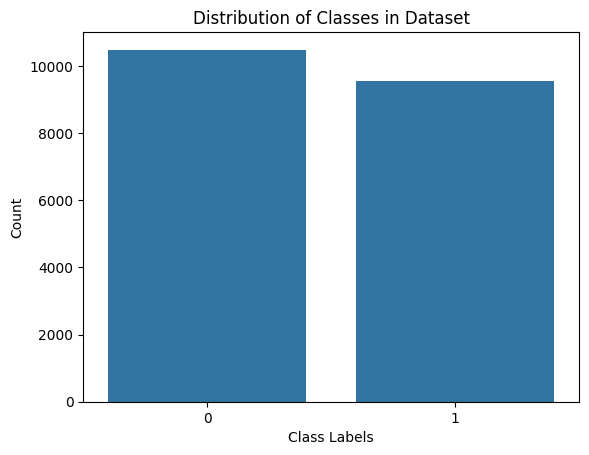

In [4]:
# Assuming x contains the value counts of 'Y' column
x = train_df['Y'].value_counts()
print(x)

# Corrected barplot call
sns.barplot(x=x.index, y=x)

# Adding a title to the bar plot
plt.xlabel('Class Labels')  # Set x-axis label
plt.ylabel('Count')         # Set y-axis label
plt.title('Distribution of Classes in Dataset')

# Show the plot with the title
plt.show()


From the above plot, it is seen that the dataset is relatively balanced with 10479 instances in class 0 and 9554 instances in class 1. Hence, we wouldn't be applying SMOTE/undersampling techniques here  

2. Missing Values

In [5]:
#missing values
train_df.isna().sum()

Y       0
text    0
dtype: int64

 3. Number of words in sarcasm from redit

In [6]:
#word count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
print("Class 1 mean word count: ", train_df[train_df['Y']==1]['word_count'].mean())


train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
print("Class 0 mean word count: ", train_df[train_df['Y']==0]['word_count'].mean())



Class 1 mean word count:  10.515804898471844
Class 0 mean word count:  9.767153354327704


The average number of words when the text is sarcasm is 10.51
The average number of words when the text is non-sarcasm is 9.76


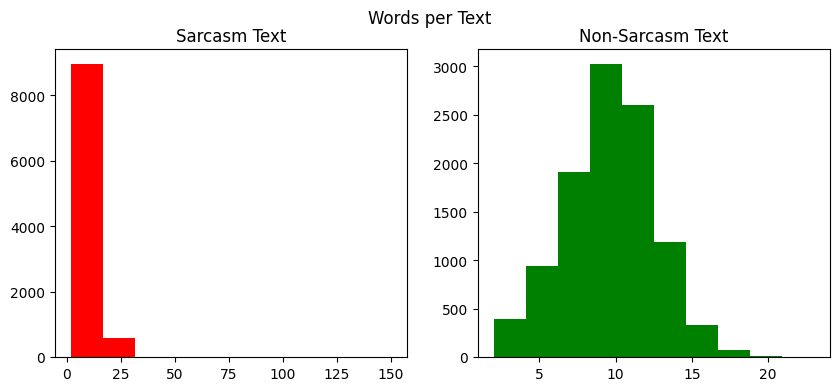

In [7]:
#plot of word count
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train_df[train_df['Y']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Sarcasm Text')

train_words=train_df[train_df['Y']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-Sarcasm Text')
fig.suptitle('Words per Text')
plt.show()


The sarcasm text is right skewed and non sarcasm text is approximately normal.
 1. Brevity in Sarcasm: Sarcasm might be more effectively conveyed in shorter sentences, which can be more direct and impactful.

 2. Nature of Dataset: The dataset you're analyzing might contain sarcastic texts that are typically short, such as tweets or headlines, which are often concise by nature.

 3. This suggests that the length of the text could be an important feature for a machine learning model designed to distinguish between sarcastic and non-sarcastic texts.

4. Number of characters in text


In [8]:
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
print("Sarcasm text",train_df[train_df['Y']==1]['char_count'].mean())
print("Non-Sarcasm Text",train_df[train_df['Y']==0]['char_count'].mean())


Sarcasm text 64.37063010257484
Non-Sarcasm Text 57.94083404905048


3. Split the train_df into train and val_df to avoid data leakagage. We will incorporate startified random sampling technique to ensure that the proportions of sarcasm and non-sarcasm are the same.

In [9]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2, random_state=42):
    """
    Splits the DataFrame into training and validation sets in a stratified manner.

    Args:
    df (DataFrame): The DataFrame to split.
    test_size (float): The proportion of the dataset to include in the validation set.
    random_state (int): The seed used by the random number generator.

    Returns:
    tuple: A tuple containing two DataFrames, the first for the training set and the second for the validation set.
    """
    # Assuming 'target' is the column name for the target variable. Replace 'target' with the actual name.
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['Y'])
    return train_df, val_df

# Use the function to split your train_df
train_df, val_df = split_data(train_df)

# Display the data
print("Training Set:", train_df.head())
print("Validation Set:", val_df.head())


Training Set:        Y                                               text  word_count  \
10014  1  sick parent offers man perfect excuse to move ...          14   
16351  0            22 animals wearing pajamas just because           6   
11461  0  down the rabbit hole tale of suicide and macaroni           9   
2197   0  kerry washington compares fashion to fine art ...          10   
7232   0  books with badass female protagonists what you...          10   

       char_count  
10014          74  
16351          39  
11461          49  
2197           61  
7232           59  
Validation Set:        Y                                               text  word_count  \
2319   0  ho ho no 5 reasons there no santa in our chris...          11   
273    0  meryl streep looks exactly like the shrek fair...          12   
280    0  donald trump vows to take travel ban to the su...          11   
8224   1  study all american problems could be solved by...          15   
10055  1          leaf t

In [10]:
print("Train: target class distribtion", train_df['Y'].value_counts())
print("Validation: target class distribution", val_df['Y'].value_counts())


Train: target class distribtion 0    8383
1    7643
Name: Y, dtype: int64
Validation: target class distribution 0    2096
1    1911
Name: Y, dtype: int64


3. Text pre-processing

Lemmatization, unlike stemming, takes into consideration the morphological analysis of the words. It aims to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.It involves a more sophisticated analysis to achieve accurate results. To lemmatize a word, it must be seen in the context of its part of speech and its meaning in the sentence. It often requires a complete vocabulary and morphological analysis of the word, and the use of a lemma dictionary.

In [11]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text


# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

'''
This funuction is needed to convert the pos_tag into wordnet pos tag
'''
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

#final pre-processing
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

train_df['clean_text'] = train_df['text'].apply(lambda x: finalpreprocess(x))
train_df.head()

val_df['clean_text'] = val_df['text'].apply(lambda x: finalpreprocess(x))
val_df.head()

,Y,text,word_count,char_count,clean_text
2319,0,ho ho no 5 reasons there no santa in our chris...,11,50,ho ho reason santa christmas
273,0,meryl streep looks exactly like the shrek fair...,12,71,meryl streep look exactly like shrek fairy god...
280,0,donald trump vows to take travel ban to the su...,11,57,donald trump vow take travel ban supreme court
8224,1,study all american problems could be solved by...,15,89,study american problem could solve stop think ...
10055,1,leaf that came out too early cold as shit,9,41,leaf come early cold shit


In [12]:
#Adding text_length to the train dataset as a feature
train_df['text_length'] = train_df['clean_text'].apply(len)
train_df.head()

,Y,text,word_count,char_count,clean_text,text_length
10014,1,sick parent offers man perfect excuse to move ...,14,74,sick parent offer man perfect excuse move back...,62
16351,0,22 animals wearing pajamas just because,6,39,animal wear pajama,18
11461,0,down the rabbit hole tale of suicide and macaroni,9,49,rabbit hole tale suicide macaroni,33
2197,0,kerry washington compares fashion to fine art ...,10,61,kerry washington compare fashion fine art mari...,54
7232,0,books with badass female protagonists what you...,10,59,book badass female protagonist go book,38


In [13]:
#Adding text_length to the train dataset as a feature on the validation dataset
val_df['text_length'] = val_df['clean_text'].apply(len)
val_df.head()

,Y,text,word_count,char_count,clean_text,text_length
2319,0,ho ho no 5 reasons there no santa in our chris...,11,50,ho ho reason santa christmas,28
273,0,meryl streep looks exactly like the shrek fair...,12,71,meryl streep look exactly like shrek fairy god...,58
280,0,donald trump vows to take travel ban to the su...,11,57,donald trump vow take travel ban supreme court,46
8224,1,study all american problems could be solved by...,15,89,study american problem could solve stop think ...,56
10055,1,leaf that came out too early cold as shit,9,41,leaf come early cold shit,25


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

# Create a TF-IDF Vectorizer instance
tfidf_vectorizer = TfidfVectorizer()

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfidf_vectorizer, 'clean_text'),  # Apply TF-IDF to 'clean_text'
        ('length', 'passthrough', ['text_length']) # Pass through 'text_length'
    ]
)


In [15]:
from sklearn.utils import shuffle

def preprocess_and_shuffle(df, preprocessor, is_fit=False):
    """
    Preprocesses the given dataframe and shuffles the data.

    Args:
    df (DataFrame): The DataFrame containing the text data and other features.
    preprocessor (ColumnTransformer): The preprocessor to apply to the DataFrame.
    is_fit (bool): If True, fit the preprocessor on the data.

    Returns:
    ndarray: An array of processed and shuffled features.
    Series: The shuffled target variable.
    """
    # Preprocess the DataFrame
    features = df[['clean_text', 'text_length']]

    # Fit the preprocessor if required, else transform
    if is_fit:
        processed_features = preprocessor.fit_transform(features)
    else:
        processed_features = preprocessor.transform(features)

    # Shuffle the data
    processed_features, target = shuffle(processed_features, df['Y'], random_state=42)

    return processed_features, target

# Fit on train data and transform train data
X_train, y_train = preprocess_and_shuffle(train_df, preprocessor, is_fit=True)

# Transform validation data
X_val, y_val = preprocess_and_shuffle(val_df, preprocessor, is_fit=False)


TF-IDF vectorizer

The Logistic Regression model then uses these TF-IDF values to classify text as sarcasm or non-sarcasm. It does this by finding patterns and relationships in the TF-IDF values across the different classes (sarcasm and non-sarcasm) in the training data. The model learns coefficients for each feature (word) that indicate how important that word is for predicting each class.



In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# FITTING THE CLASSIFICATION MODEL using Multinomial Naive Bayes
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train, y_train)  # Use the already preprocessed and split X_train

# Predict y values for the training dataset
y_predict_train = nb_tfidf.predict(X_train)  # Use X_train for train predictions
y_prob_train = nb_tfidf.predict_proba(X_train)[:, 1]

# Predict y values for the validation dataset
y_predict_val = nb_tfidf.predict(X_val)  # Use X_val for predictions
y_prob_val = nb_tfidf.predict_proba(X_val)[:, 1]

#Train Confusion matrix Evaluation
print(classification_report(y_train, y_predict_train))
print('Confusion Matrix:\n', confusion_matrix(y_train, y_predict_train))

# Validation Confusion matrix Evaluation
print(classification_report(y_val, y_predict_val))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_predict_val))

# If you're working with a binary classification problem, you could calculate the AUC
# However, if it's a multi-class classification, you would need to adjust this accordingly
fpr, tpr, thresholds = roc_curve(y_val, y_prob_val)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)


              precision    recall  f1-score   support

           0       0.91      0.90      0.91      8383
           1       0.90      0.91      0.90      7643

    accuracy                           0.90     16026
   macro avg       0.90      0.90      0.90     16026
weighted avg       0.90      0.90      0.90     16026

Confusion Matrix:
 [[7574  809]
 [ 723 6920]]
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2096
           1       0.78      0.77      0.78      1911

    accuracy                           0.79      4007
   macro avg       0.79      0.79      0.79      4007
weighted avg       0.79      0.79      0.79      4007

Confusion Matrix:
 [[1671  425]
 [ 432 1479]]
AUC: 0.8717878813298661


In [17]:
from sklearn.metrics import confusion_matrix

# Predictions on the training set
y_train_pred = nb_tfidf.predict(X_train)

# Predictions on the validation set
y_val_pred = nb_tfidf.predict(X_val)

# Confusion matrices
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

# Printing the confusion matrices with labels
print("Confusion Matrix for Training Set:")
print("TN", "FP")
print(conf_matrix_train[0])  # True Negative, False Positive
print("FN", "TP")
print(conf_matrix_train[1])  # False Negative, True Positive

print("\nConfusion Matrix for Validation Set:")
print("TN", "FP")
print(conf_matrix_val[0])  # True Negative, False Positive
print("FN", "TP")
print(conf_matrix_val[1])  # False Negative, True Positive


Confusion Matrix for Training Set:
TN FP
[7574  809]
FN TP
[ 723 6920]

Confusion Matrix for Validation Set:
TN FP
[1671  425]
FN TP
[ 432 1479]


In [24]:
def plot_confusion_matrix(y_train, train_yhat_probs, classes):
        train_cm = confusion_matrix(y_train, train_yhat_probs)
        ax = sns.heatmap(train_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Training Confusion Matrix')
        plt.show()

In [27]:
def calculate_classification_report(y_train, train_yhat_probs,classes):
        report = classification_report(y_train, train_yhat_probs, target_names=classes)
        return report

Training Classification Report:
               precision    recall  f1-score   support

 Non-Sarcasm       0.91      0.90      0.91      8383
     Sarcasm       0.90      0.91      0.90      7643

    accuracy                           0.90     16026
   macro avg       0.90      0.90      0.90     16026
weighted avg       0.90      0.90      0.90     16026



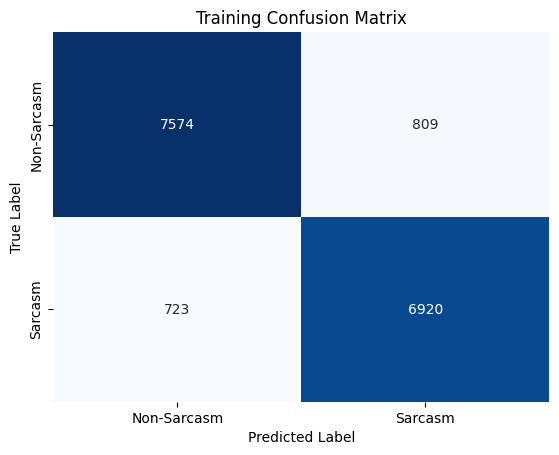

Validation Classification Report:
               precision    recall  f1-score   support

 Non-Sarcasm       0.79      0.80      0.80      2096
     Sarcasm       0.78      0.77      0.78      1911

    accuracy                           0.79      4007
   macro avg       0.79      0.79      0.79      4007
weighted avg       0.79      0.79      0.79      4007



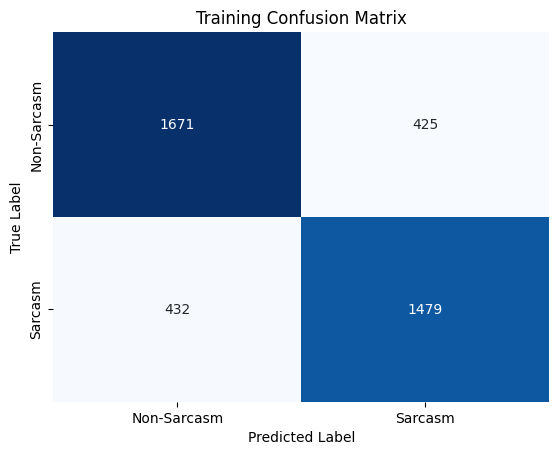


 ROC Curve


In [30]:
classes = ["Non-Sarcasm", "Sarcasm"]


train_classification_report = calculate_classification_report(y_train, y_train_pred,classes)
print("Training Classification Report:\n", train_classification_report)

# Plot the training confusion matrix
plot_confusion_matrix(y_train, y_train_pred,classes)


val_classification_report = calculate_classification_report(y_val, y_val_pred,classes)
print("Validation Classification Report:\n", val_classification_report)

# Plot the Validation confusion matrix
plot_confusion_matrix(y_val, y_val_pred,classes)

print("\n ROC Curve")
#plot ROC Curve
y_true = y_val
y_scores = y_val_pred


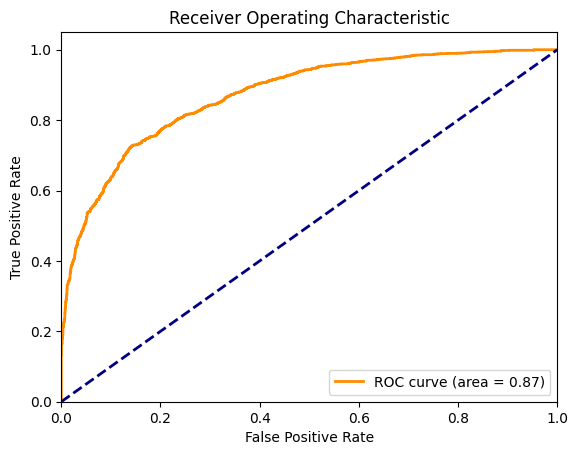

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_val is your validation target and y_prob_val are the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_val, y_prob_val)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


The AUC (Area Under the Curve) value is 0.87, which is quite good. The fact that the curve stays well above the diagonal line of no-discrimination (the dashed line) indicates that the model has a good measure of separability and is able to distinguish between the positive class and the negative class effectively